<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/Engineering-Mathematics/blob/main/Hodgkin_Huxley_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hodgkin-Huxley 모델**은 뉴런의 활동 전위를 수학적으로 모델링한 것입니다. 이 모델은 신경 세포의 막 전위 변화를 나트륨(Na⁺), 칼륨(K⁺) 및 누출 전류(Leakage current)와 관련된 방정식으로 설명합니다. 이 방정식은 각 이온 채널의 전도도와 막 전위 차이에 따라 뉴런의 활동 전위를 계산하는 방식입니다.

Hodgkin-Huxley 모델은 여러 미분 방정식으로 이루어져 있으며, 이를 **수치적 방법**으로 풀어야 합니다. 주로 **Euler 방법** 또는 **Runge-Kutta 방법** 같은 수치적 기법이 사용됩니다. Python에서는 주로 **SciPy** 라이브러리의 **odeint** 함수나 **RK4** 방법을 이용해 풀 수 있습니다.

### Hodgkin-Huxley 모델 방정식:

- 나트륨(Na⁺) 전류:
    
    $$I_{Na} = g_{Na} m^3 h (V - V_{Na})$$
    
- 칼륨(K⁺) 전류:
    
    $$I_K = g_K n^4 (V - V_K)$$
    
- 누출 전류:
    
    $$I_L = g_L (V - V_L)$$
    
- 총 전류:
    
    $$I = C_m \frac{dV}{dt} = I_{Na} + I_K + I_L$$
    

### 파라미터:

- $g_{Na}, g_K, g_L$: 각각 나트륨, 칼륨, 누출 전도도
- $V_{Na}, V_K, V_L$: 각 이온의 평형 전위
- $C_m$: 막 정전 용량
- $m, h, n$: 이온 채널의 활성화/불활성화 변수

In [2]:
# Google Colab에 NanumGothic 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
# Import the font_manager module from matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt


# 설치된 폰트 확인 및 matplotlib에 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123622 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


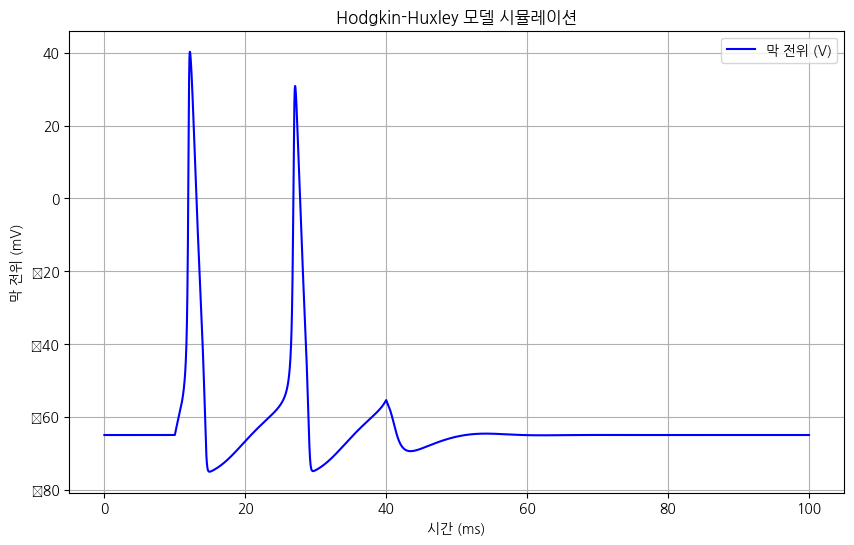

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# 상수들
C_m = 1.0  # 막 정전 용량 (uF/cm^2)
g_Na = 120.0  # 나트륨 전도도 (mS/cm^2)
g_K = 36.0  # 칼륨 전도도 (mS/cm^2)
g_L = 0.3  # 누출 전도도 (mS/cm^2)
V_Na = 50.0  # 나트륨 평형 전위 (mV)
V_K = -77.0  # 칼륨 평형 전위 (mV)
V_L = -54.387  # 누출 평형 전위 (mV)

# 나트륨 활성화 m, 불활성화 h, 칼륨 활성화 n의 시간에 따른 변화
def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1.0 / (1 + np.exp(-(V + 35) / 10))

def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

# 전류 방정식 (Nernst 방정식)
def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - V_Na)

def I_K(V, n):
    return g_K * n**4 * (V - V_K)

def I_L(V):
    return g_L * (V - V_L)

# 미분 방정식 시스템 정의
def Hodgkin_Huxley(X, t):
    V, m, h, n = X

    # 미분 방정식들
    dVdt = (I_inj(t) - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n

    return [dVdt, dmdt, dhdt, dndt]

# 외부 자극 전류 함수
def I_inj(t):
    if 10 < t < 40:  # 10 ms에서 40 ms까지 10 uA/cm^2의 전류 자극
        return 10.0
    else:
        return 0.0

# 초기 조건 설정
V0 = -65.0  # 초기 막 전위 (mV)
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))  # 나트륨 활성화 변수 초기값
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))  # 나트륨 불활성화 변수 초기값
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))  # 칼륨 활성화 변수 초기값

# 초기 상태
X0 = [V0, m0, h0, n0]

# 시간 범위 설정 (0 ~ 100 ms)
t = np.linspace(0, 100, 10000)

# ODE 풀이
X = odeint(Hodgkin_Huxley, X0, t)

# 결과 추출
V = X[:, 0]  # 막 전위
m = X[:, 1]
h = X[:, 2]
n = X[:, 3]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(t, V, label="막 전위 (V)", color='b')
plt.title("Hodgkin-Huxley 모델 시뮬레이션")
plt.ylabel("막 전위 (mV)")
plt.xlabel("시간 (ms)")
plt.grid()
plt.legend()
plt.show()




### 코드 설명:

1. **모델 상수**: 나트륨, 칼륨, 그리고 누출 전도도 및 평형 전위를 설정합니다.
2. **이온 채널 전도율**: $α$와 $β$ 함수를 통해 나트륨과 칼륨 이온 채널의 활성화 및 불활성화 비율을 계산합니다.
3. **미분 방정식 정의**: `Hodgkin_Huxley` 함수는 Hodgkin-Huxley 모델을 수치적으로 풀기 위한 4개의 상미분 방정식을 정의합니다. 막 전위 V와 나트륨 및 칼륨 이온 채널의 변화를 설명합니다.
4. **외부 자극 전류**: $I_{inj}(t)$는 10 ms에서 40 ms까지 외부에서 가해지는 전류 자극을 제공합니다.
5. **초기 조건**: 막 전위 $V_0$와 각 이온 채널의 초기 상태 $m_0, h_0, n_0$를 설정합니다.
6. **수치적 해석**: `odeint` 함수를 사용하여 미분 방정식을 풀고, 시간에 따른 막 전위와 이온 채널의 변화를 계산합니다.
7. **결과 시각화**: 시간에 따른 막 전위 변화를 그래프로 출력합니다.

### 추가 확장:

- **다양한 자극 전류**: 자극 전류 $I_inj(t)$의 형태를 변화시켜 더 복잡한 자극을 시뮬레이션할 수 있습니다.
- **다양한 파라미터 설정**: 나트륨, 칼륨 전도도나 평형 전위 값을 변경하여 신경 세포의 다른 특성을 분석할 수 있습니다.